In [15]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import numpy.ma as ma

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19

path_to_save = '../../figures/'


In [16]:
import covid19_inference.model_helper as mh
from covid19_inference.models import _SIR_model
import theano.tensor as tt

def SIR_with_change_points_and_mask(
    new_cases_obs,
    change_points_list,
    date_begin_simulation,
    num_days_sim,
    diff_data_sim,
    N, mask,
    priors_dict=None, 
):
    """
        Parameters
        ----------
        new_cases_obs : list or array
            Timeseries (day over day) of newly reported cases (not the total number)

        change_points_list : list of dicts
            List of dictionaries, each corresponding to one change point.

            Each dict can have the following key-value pairs. If a pair is not provided,
            the respective default is used.
                * pr_mean_date_begin_transient :     datetime.datetime, NO default
                * pr_median_lambda :                 number, same as default priors, below
                * pr_sigma_lambda :                  number, same as default priors, below
                * pr_sigma_date_begin_transient :    number, 3
                * pr_median_transient_len :          number, 3
                * pr_sigma_transient_len :           number, 0.3

        date_begin_simulation: datetime.datetime
            The begin of the simulation data

        num_days_sim : integer
            Number of days to forecast into the future

        diff_data_sim : integer
            Number of days that the simulation-begin predates the first data point in
            `new_cases_obs`. This is necessary so the model can fit the reporting delay.
            Set this parameter to a value larger than what you expect to find
            for the reporting delay.

        N : number
            The population size. For Germany, we used 83e6

        priors_dict : dict
            Dictionary of the prior assumptions

            Possible key-value pairs (and default values) are:
                * pr_beta_I_begin :        number, default = 100
                * pr_median_lambda_0 :     number, default = 0.4
                * pr_sigma_lambda_0 :      number, default = 0.5
                * pr_median_mu :           number, default = 1/8
                * pr_sigma_mu :            number, default = 0.2
                * pr_median_delay :        number, default = 8
                * pr_sigma_delay :         number, default = 0.2
                * pr_beta_sigma_obs :      number, default = 10

        Returns
        -------
        : pymc3.Model
            Returns an instance of pymc3 model with the change points

    """
    if priors_dict is None:
        priors_dict = dict()

    default_priors = dict(
        pr_beta_I_begin=100,
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        pr_median_mu=1 / 8,
        pr_sigma_mu=0.2,
        pr_median_delay=8,
        pr_sigma_delay=0.2,
        pr_beta_sigma_obs=10,
    )
    default_priors_change_points = dict(
        pr_median_lambda=default_priors["pr_median_lambda_0"],
        pr_sigma_lambda=default_priors["pr_sigma_lambda_0"],
        pr_sigma_date_begin_transient=3,
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_mean_date_begin_transient=None,
    )

    for prior_name in priors_dict.keys():
        if prior_name not in default_priors:
            raise RuntimeError(f"Prior with name {prior_name} not known")
    for change_point in change_points_list:
        for prior_name in change_point.keys():
            if prior_name not in default_priors_change_points:
                raise RuntimeError(f"Prior with name {prior_name} not known")

    for prior_name, value in default_priors.items():
        if prior_name not in priors_dict:
            priors_dict[prior_name] = value
            print(f"{prior_name} was set to default value {value}")
    for prior_name, value in default_priors_change_points.items():
        for i_cp, change_point in enumerate(change_points_list):
            if prior_name not in change_point:
                change_point[prior_name] = value
                print(
                    f"{prior_name} of change point {i_cp} was set to default value {value}"
                )

    if (
        diff_data_sim
        < priors_dict["pr_median_delay"]
        + 3 * priors_dict["pr_median_delay"] * priors_dict["pr_sigma_delay"]
    ):
        raise RuntimeError("diff_data_sim is to small compared to the prior delay")
    if num_days_sim < len(new_cases_obs) + diff_data_sim:
        raise RuntimeError(
            "Simulation ends before the end of the data. Increase num_days_sim."
        )

    # ------------------------------------------------------------------------------ #
    # Model and prior implementation
    # ------------------------------------------------------------------------------ #

    with pm.Model() as model:
        # all pm functions now apply on the model instance
        # true cases at begin of loaded data but we do not know the real number
        I_begin = pm.HalfCauchy(name="I_begin", beta=priors_dict["pr_beta_I_begin"])

        # fraction of people that are newly infected each day
        lambda_list = []
        lambda_list.append(
            pm.Lognormal(
                name="lambda_0",
                mu=np.log(priors_dict["pr_median_lambda_0"]),
                sigma=priors_dict["pr_sigma_lambda_0"],
            )
        )
        for i, cp in enumerate(change_points_list):
            lambda_list.append(
                pm.Lognormal(
                    name=f"lambda_{i + 1}",
                    mu=np.log(cp["pr_median_lambda"]),
                    sigma=cp["pr_sigma_lambda"],
                )
            )

        # list of start dates of the transient periods of the change points
        tr_begin_list = []
        dt_before = date_begin_simulation
        for i, cp in enumerate(change_points_list):
            dt_begin_transient = cp["pr_mean_date_begin_transient"]
            if dt_before is not None and dt_before > dt_begin_transient:
                raise RuntimeError("Dates of change points are not temporally ordered")

            prior_mean = (
                dt_begin_transient - date_begin_simulation
            ).days  # convert the provided date format (argument) into days (a number)

            tr_begin = pm.Normal(
                name=f"transient_begin_{i}",
                mu=prior_mean,
                sigma=cp["pr_sigma_date_begin_transient"],
            )
            tr_begin_list.append(tr_begin)
            dt_before = dt_begin_transient

        # same for transient times
        tr_len_list = []
        for i, cp in enumerate(change_points_list):
            tr_len = pm.Lognormal(
                name=f"transient_len_{i}",
                mu=np.log(cp["pr_median_transient_len"]),
                sigma=cp["pr_sigma_transient_len"],
            )
            tr_len_list.append(tr_len)

        # build the time-dependent spreading rate
        lambda_t_list = [lambda_list[0] * tt.ones(num_days_sim)]
        lambda_before = lambda_list[0]

        for tr_begin, tr_len, lambda_after in zip(
            tr_begin_list, tr_len_list, lambda_list[1:]
        ):
            lambda_t = mh.smooth_step_function(
                start_val=0,
                end_val=1,
                t_begin=tr_begin,
                t_end=tr_begin + tr_len,
                t_total=num_days_sim,
            ) * (lambda_after - lambda_before)
            lambda_before = lambda_after
            lambda_t_list.append(lambda_t)
        lambda_t = sum(lambda_t_list)

        # fraction of people that recover each day, recovery rate mu
        mu = pm.Lognormal(
            name="mu",
            mu=np.log(priors_dict["pr_median_mu"]),
            sigma=priors_dict["pr_sigma_mu"],
        )

        # delay in days between contracting the disease and being recorded
        delay = pm.Lognormal(
            name="delay",
            mu=np.log(priors_dict["pr_median_delay"]),
            sigma=priors_dict["pr_sigma_delay"],
        )

        # prior of the error of observed cases
        sigma_obs = pm.HalfCauchy("sigma_obs", beta=priors_dict["pr_beta_sigma_obs"])

        # -------------------------------------------------------------------------- #
        # training the model with loaded data provided as argument
        # -------------------------------------------------------------------------- #

        S_begin = N - I_begin
        S, I, new_I = _SIR_model(
            lambda_t=lambda_t, mu=mu, S_begin=S_begin, I_begin=I_begin, N=N
        )

        new_cases_inferred = mh.delay_cases(
            new_I_t=new_I,
            len_new_I_t=num_days_sim,
            len_out=num_days_sim - diff_data_sim,
            delay=delay,
            delay_diff=diff_data_sim,
        )
        num_days_data = new_cases_obs.shape[-1]

        # likelihood of the model:
        # observed cases are distributed following studentT around the model.
        # we want to approximate a Poisson distribution of new cases.
        # we choose nu=4 to get heavy tails and robustness to outliers.
        # https://www.jstor.org/stable/2290063
        pm.StudentT(
            name="_new_cases_studentT",
            nu=4,
            mu=new_cases_inferred[:num_days_data][mask],
            sigma=tt.abs_(new_cases_inferred[:num_days_data][mask] + 1) ** 0.5
            * sigma_obs,  # +1 and tt.abs to avoid nans
            observed=new_cases_obs[mask],
        )

        # add these observables to the model so we can extract a time series of them
        # later via e.g. `model.trace['lambda_t']`
        pm.Deterministic("lambda_t", lambda_t)
        pm.Deterministic("new_cases", new_cases_inferred)

    return model

In [17]:

confirmed_cases = cov19.get_jhu_confirmed_cases()



country = 'Germany'
date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]

traces = []
models = []

new_cases_obs = np.diff(cases_obs)
mask = []
for i in range(num_days_data):
    date_curr = date_data_begin + datetime.timedelta(days=i+1)
    if not date_curr.isoweekday() in (6,7):
        mask.append(i)

for num_change_points in range(0,4):
    model = SIR_with_change_points_and_mask(new_cases_obs,
                                        change_points_list = change_points[:num_change_points],
                                        date_begin_simulation = date_begin_sim,
                                        num_days_sim = num_days_sim,
                                        diff_data_sim = diff_data_sim,
                                        N = 83e6, mask=mask,
                                        priors_dict=None)
    models.append(model)
    traces.append(pm.sample(model=model, init='advi', draws=3000))

Cases yesterday (2020-04-08T00:00:00): 113296 and day before yesterday: 107663
pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 277.05:   6%|▌         | 11546/200000 [00:19<05:11, 604.24it/s]
Convergence achieved at 11600
Interrupted at 11,599 [5%]: Average Loss = 372.61
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, lambda_0, I_begin]
Sampling 4 chains, 13 divergences: 100%|██████████| 14000/14000 [05:28<00:00, 42.67draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 0 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 271.53:   7%|▋         | 13064/200000 [00:27<06:26, 483.45it/s]
Convergence achieved at 13100
Interrupted at 13,099 [6%]: Average Loss = 348.85
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, transient_len_0, transient_begin_0, lambda_1, lambda_0, I_begin]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [19:12<00:00, 12.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 1 was set to default value 3
pr_sigma_transient_len of change point 1 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 267.17:   7%|▋         | 14496/200000 [00:54<11:43, 263.70it/s]
Convergence achieved at 14500
Interrupted at 14,499 [7%]: Average Loss = 339.45
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, transient_len_1, transient_len_0, transient_begin_1, transient_begin_0, lambda_2, lambda_1, lambda_0, I_begin]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [18:59<00:00, 12.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 2 was set to default value 3
pr_sigma_transient_len of change point 2 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 270.32:   7%|▋         | 13377/200000 [00:41<09:41, 321.03it/s]
Convergence achieved at 13400
Interrupted at 13,399 [6%]: Average Loss = 346.15
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, lambda_3, lambda_2, lambda_1, lambda_0, I_begin]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [21:07<00:00, 11.04draws/s]


Plots with data from 2020-03-01 to 2020-04-08
[737486. 737496.]


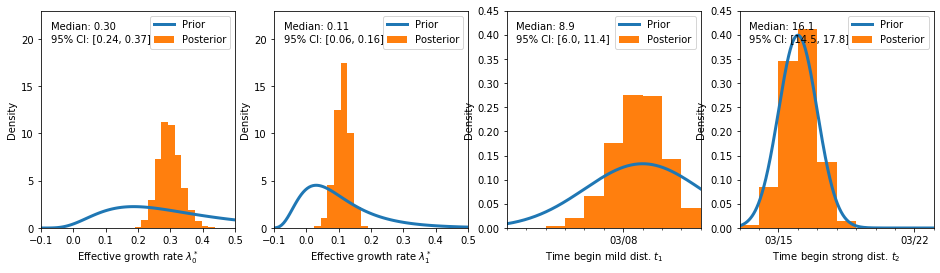

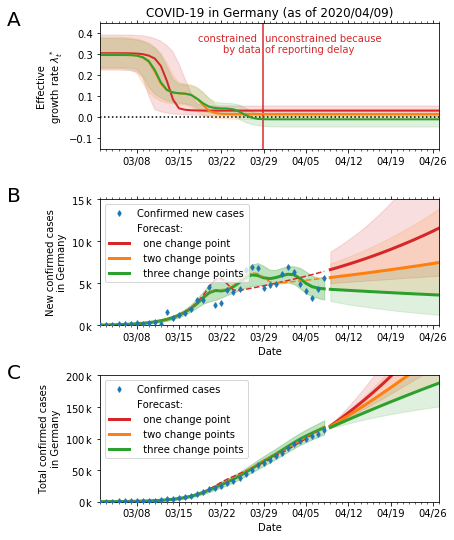

In [18]:
def truncate_number(number, precision):
    return '{{:.{}f}}'.format(precision).format(number)  

def print_median_CI(arr, prec = 2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = f_trunc(np.percentile(arr, q=2.5)), f_trunc(np.percentile(arr, q=97.5))
    return 'Median: {}\n95% CI: [{}, {}]'.format(med, perc1, perc2)
def conv_time_to_mpl_dates(arr):
    return matplotlib.dates.date2num([datetime.timedelta(days=float(date)) + date_begin_sim for date in arr])

print("Plots with data from {} to {}".format(date_data_begin.date().isoformat(), date_data_end.date().isoformat()))

trace = traces[3]
posterior = traces[1:]


fig, axes = plt.subplots(1,4, figsize=(16, 4))
#plt.locator_params(nbins=4)
pos_letter = (-0.2, 1)


limit_lambda = (-0.1,0.5)
bins_lambda  = np.linspace(*limit_lambda, 30)


ax = axes[0]
ax.hist(trace.lambda_0 - trace.mu, bins=bins_lambda, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x+1/8, scale=0.4, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_ylabel('Density')
ax.set_xlabel('Effective growth rate $\lambda_0^*$')
text = print_median_CI(trace.lambda_0 - trace.mu, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
ax.set_ylim(0,23)


ax = axes[1]
ax.hist(trace.lambda_1 - trace.mu, bins=bins_lambda, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x+1/8, scale=0.2, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_ylabel('Density')
ax.set_xlabel('Effective growth rate $\lambda_1^*$')
text = print_median_CI(trace.lambda_1 - trace.mu, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
ax.set_ylim(0,23)



diff_to_0 = num_days_data + diff_data_sim 


dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)

ax = axes[2]
limits = matplotlib.dates.date2num([datetime.date(2020,3,2), datetime.date(2020,3,12)])
bins = np.arange(limits[0], limits[1]+1)
ax.hist(dates_mild, bins=bins, density=True, color='tab:orange',
        label='Posterior')
#limits = ax.get_xlim()
x = np.linspace(*limits, num=1000)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(limits[0], limits[1])
ax.set_ylabel('Density')
ax.set_xlabel('Time begin mild dist. $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_ylim(0,0.45)
print(limits)

ax = axes[3]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_1)
limits = matplotlib.dates.date2num([datetime.date(2020,3,13), datetime.date(2020,3,23)])
bins = np.arange(limits[0], limits[1]+1)
ax.hist(dates_strong, bins=bins, density=True, color='tab:orange',
        label='Posterior')
#limits = ax.get_xlim()
x = np.linspace(*limits, num=1000)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(limits[0], limits[1])
ax.set_ylabel('Density')
ax.set_xlabel('Time begin strong dist. $t_2$')
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
#ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_ylim(0,0.45)
ax.set_xlim(limits[0], limits[1])



# plt.savefig(path_to_save + 'summary_distributions.png', dpi=300)
# plt.savefig(path_to_save + 'summary_distributions.pdf', dpi=300)


fig, axes = plt.subplots(3,1, figsize=(6.5,7.5), gridspec_kw={'height_ratios': [2, 2,2]})

colors  = ['tab:red', 'tab:orange', 'tab:green']
legends = ['Forecast: ', '  one change point', '  two change points',  '  three change points']

ax = axes[1]

time1 = np.arange(-len(cases_obs)+2, 1)
mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
start_date = mpl_dates[0]
diff_cases =np.diff(cases_obs)
ax.plot(mpl_dates, diff_cases, 'd', label='Confirmed new cases', markersize=4, color='tab:blue', 
            zorder=5)
#ax.plot(mpl_dates, diff_cases, 'd', markersize=4, color='tab:blue', 
#            zorder=6)

new_cases_past = trace.new_cases[:,:num_days_data]
percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(new_cases_past, axis=0),color='tab:green', linewidth=3, zorder=-1)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:green')

ax.plot([],[], label=legends[0], alpha=0)
for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
    new_cases_past = trace_scen.new_cases[:,:num_days_data]
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),'--',color=color, linewidth=1.5)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    end_date = mpl_dates_fut[-10]
    cases_future = trace_scen['new_cases'][:, num_days_data:].T
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*diff_cases[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
    np.percentile(cases_future, q=2.5, axis=-1),
    np.percentile(cases_future, q=97.5, axis=-1),
    )

    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.15, color=color)
    #ax.fill_between(mpl_dates, np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
    #            alpha=0.2, color=color)

ax.set_xlabel('Date')
ax.set_ylabel('New confirmed cases\nin Germany')
ax.legend(loc='upper left')
ax.set_ylim(0, 15_000)
# ax.legend(loc='lower left')
#ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
#ax.set_xlim(-28, 14)
ax.locator_params(axis="y", nbins=4)
func_format = lambda num, _: "${:.0f}\,$k".format(num/1_000)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.text(-0.275, 0.98, "B", transform=ax.transAxes, size=20)
ax.xaxis.set_ticks_position('both')


ax=axes[2]

time1 = np.arange(-len(cases_obs)+2, 1)
mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
ax.plot(mpl_dates, cases_obs[1:], 'd', label='Confirmed cases', markersize=4, color='tab:blue', 
            zorder=5)
#ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
#            zorder=6)

cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:green', linewidth=3, zorder=-1)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:green')

ax.plot([],[], label=legends[0], alpha=0)
for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
    new_cases_past = trace_scen.new_cases[:,:num_days_data]
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),'--',color=color, linewidth=1.5)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = np.cumsum(trace_scen['new_cases'][:, num_days_data:].T, axis=0) + cases_obs[-1]
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.15, color=color)
    #ax.fill_between(mpl_dates, np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
    #                alpha=0.2, color=color)

ax.set_xlabel('Date')
ax.set_ylabel('Total confirmed cases\nin Germany')
ax.legend(loc='upper left')
ax.set_ylim(0, 200_000)
# ax.legend(loc='lower left')
#ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
#ax.set_xlim(-28, 14)
ax.locator_params(axis="y", nbins=4)
func_format = lambda num, _: "${:.0f}\,$k".format(num/1_000)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.text(-0.275, 0.98, "C", transform=ax.transAxes, size=20)


ax = axes[0]

time = np.arange(-diff_to_0+1, -diff_to_0+num_days_sim+1)

for trace_scen, color in zip(posterior, colors):

    lambda_t = trace_scen['lambda_t'][:, :]
    mu = trace_scen['mu'][:,None]
    mpl_dates = conv_time_to_mpl_dates(time) + diff_data_sim + num_days_data

    ax.plot(mpl_dates, np.median(lambda_t-mu, axis=0), color=color, linewidth=2)
    ax.fill_between(mpl_dates, np.percentile(lambda_t-mu , q=2.5, axis=0),np.percentile(lambda_t-mu, q=97.5, axis=0), alpha=0.15,
                    color=color)
    #ax.fill_between(mpl_dates, np.percentile(lambda_t , q=12.5, axis=0),np.percentile(lambda_t, q=87.5, axis=0), alpha=0.2,
    #                color=color)

ax.set_ylabel('Effective\ngrowth rate $\lambda_t^*$')
# ax.set_xlabel("days from now")
# ax.legend(loc='lower left')
ax.set_xticks([-28, -21, -14, -7, 0, 7, 14, 21, 28])
#ax.set_xlim(-28, 14)
ax.set_ylim(-0.15, 0.45)
#ax.set_yticks([-0.2, 0, 0.2])
#ax.set_aspect(15, adjustable="box")
ax.hlines(0,start_date, end_date, linestyles=':')
delay = matplotlib.dates.date2num(date_data_end) - np.percentile(trace.delay, q=75)
ax.vlines(delay,-10, 10, linestyles='-', colors=['tab:red'])
#ax.legend()
ax.text(delay+0.4, 0.4, 'unconstrained because\nof reporting delay', color='tab:red', verticalalignment='top')
ax.text(delay-0.4, 0.4, 'constrained \nby data', color='tab:red',horizontalalignment='right', verticalalignment='top')
ax.text(-0.275, 0.98, "A", transform=ax.transAxes, size=20)
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.xaxis.set_ticks_position('both')

fig.subplots_adjust(hspace=-0.90)
plt.tight_layout()

plt.savefig(path_to_save + 'summary_forecast_no_weekend.pdf', dpi=300)
axes[0].set_title('COVID-19 in Germany (as of {})'.format((date_data_end + datetime.timedelta(days=1)).strftime('%Y/%m/%d')))
plt.savefig(path_to_save + 'summary_forecast_no_weekend.png', dpi=300)

Plots with data from 2020-03-01 to 2020-04-08


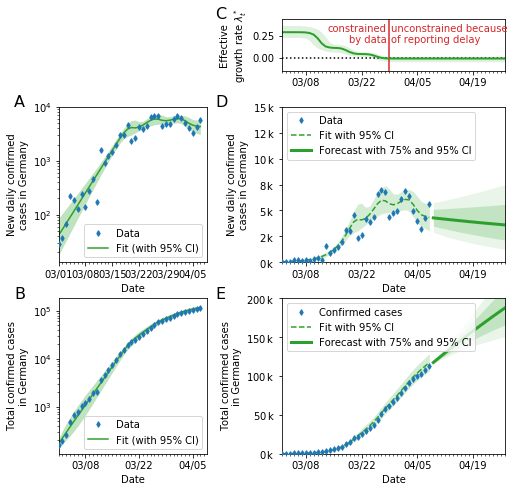

In [19]:


print("Plots with data from {} to {}".format(date_data_begin.date().isoformat(), date_data_end.date().isoformat()))

ylabel_new = 'New daily confirmed\ncases in Germany'
ylabel_cum = 'Total confirmed cases\nin Germany'


for trace, color, save_name in zip((traces[-1:]),
                                   ('tab:green',),
                                   ('Fig_cases_no_weekend',)):

    fig, axes = plt.subplots(3,2, figsize=(8,8), gridspec_kw={'height_ratios': [1, 3,3],
                                                                'width_ratios': [2, 3]})
    #plt.locator_params(nbins=4)
    pos_letter = (-0.3, 1)
    titlesize = 16

    ax = axes[1][0]
    time_arr = np.arange(-len(cases_obs)+1, 0)
    mpl_dates = conv_time_to_mpl_dates(time_arr) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, np.diff(cases_obs), 'd', markersize=4, label='Data', zorder=5)
    new_cases_past = trace.new_cases[:,:num_days_data]
    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),color=color, label='Fit (with 95% CI)')
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color=color, lw=0)
    ax.set_yscale('log')
    ax.set_ylabel(ylabel_new)
    ax.set_xlabel('Date')
    ax.legend()
    ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(mpl_dates[0])

    #plt.savefig(path_to_save + 'check_new_cases.png', dpi=300)

    ax = axes[2][0]
    ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, label='Data', zorder=5)
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),color=color, label='Fit (with 95% CI)')
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color=color, lw=0)
    ax.set_yscale('log')
    ax.set_ylabel(ylabel_cum)
    ax.set_xlabel('Date')
    ax.legend()
    ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(mpl_dates[0])

    ax = axes[1][1]

    time1 = np.arange(-len(cases_obs)+2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, np.diff(cases_obs), 'd', label='Data', markersize=4, color='tab:blue', 
                zorder=5)
    #ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
    #            zorder=6)

    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    #ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:orange', linewidth=3)
    #ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')


    new_cases_past = trace.new_cases[:,:num_days_data]
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),'--',color=color, linewidth=1.5, label='Fit with 95% CI')
    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.2, color=color, lw=0)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = trace['new_cases'][:, num_days_data:].T
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label='Forecast with 75% and 95% CI')
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.1, color=color, lw=0)
    ax.fill_between(mpl_dates_fut[1:], np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
                    alpha=0.2, color=color, lw=0)

    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel_new)
    ax.legend(loc='upper left')
    ax.set_ylim(0, 15_000)
    # ax.legend(loc='lower left')
    #ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    #ax.locator_params(axis="y", nbins=4)
    func_format =lambda num, _: "${:.0f}\,$k".format(num/1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "D", transform=ax.transAxes, size=titlesize)


    ax = axes[2][1]

    time1 = np.arange(-len(cases_obs)+2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, cases_obs[1:], 'd', label='Confirmed cases', markersize=4, color='tab:blue', 
                zorder=5)
    #ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
    #            zorder=6)


    new_cases_past = trace.new_cases[:,:num_days_data]
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),'--',color=color, linewidth=1.5, label='Fit with 95% CI')
    percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.2, color=color, lw=0)


    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = np.cumsum(trace['new_cases'][:, num_days_data:].T, axis=0) + cases_obs[-1]
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label='Forecast with 75% and 95% CI')
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.1, color=color, lw=0)
    ax.fill_between(mpl_dates_fut[1:], np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
                    alpha=0.2, color=color, lw=0)

    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel_cum)
    ax.legend(loc='upper left')
    ax.set_ylim(0, 200_000)
    # ax.legend(loc='lower left')
    #ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    #ax.locator_params(axis="y", nbins=4)
    func_format =lambda num, _: "${:.0f}\,$k".format(num/1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=titlesize)


    ax = axes[0][1]

    time = np.arange(-diff_to_0+1, -diff_to_0+num_days_sim+1)
    lambda_t = trace['lambda_t'][:, :]
    mu = trace['mu'][:,None]
    mpl_dates = conv_time_to_mpl_dates(time) + diff_data_sim + num_days_data

    ax.plot(mpl_dates, np.median(lambda_t-mu, axis=0), color=color, linewidth=2)
    ax.fill_between(mpl_dates, np.percentile(lambda_t-mu , q=2.5, axis=0),np.percentile(lambda_t-mu, q=97.5, axis=0), alpha=0.15,
                    color=color, lw=0)
    #ax.fill_between(mpl_dates, np.percentile(lambda_t , q=12.5, axis=0),np.percentile(lambda_t, q=87.5, axis=0), alpha=0.2,
    #                color=color)

    ax.set_ylabel('Effective\ngrowth rate $\lambda_t^*$')
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    # ax.set_xticks([-28, -21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    ax.set_ylim(-0.15, 0.45)
    #ax.set_yticks([-0.2, 0, 0.2])
    #ax.set_aspect(15, adjustable="box")
    ax.hlines(0,start_date, end_date, linestyles=':')
    delay = matplotlib.dates.date2num(date_data_end) - np.percentile(trace.delay, q=75)
    ax.vlines(delay,-10, 10, linestyles='-', colors=['tab:red'])
    #ax.legend()
    ax.text(delay+0.5, 0.4, 'unconstrained because\nof reporting delay', color='tab:red', verticalalignment='top')
    ax.text(delay-0.5, 0.4, 'constrained\nby data', color='tab:red',horizontalalignment='right', verticalalignment='top')
    ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)

    axes[0][0].set_visible(False)

    plt.subplots_adjust(wspace=0.4, hspace=.3)
    plt.savefig(path_to_save + save_name + '.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
    plt.savefig(path_to_save + save_name + '.png', dpi=300, bbox_inches='tight', pad_inches = 0)

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:295: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


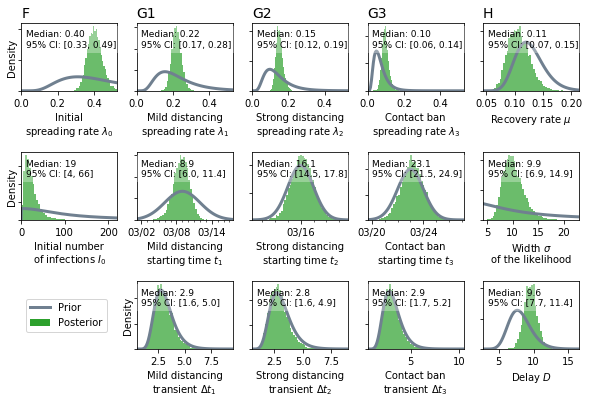

In [20]:
trace=traces[-1]
diff_to_0 = num_days_data + diff_data_sim 
colors = ['#708090', 'tab:green']

fig, axes = plt.subplots(3,5, figsize=(10,6))
#plt.locator_params(nbins=4)
pos_letter = (0, 1.08)
pos_median = (0.05,0.9)
size_letters=14
alpha_texbox=.3
font_text=9
horizontal_alignment_median = 'left'
horizontal_alignment_letter = 'left'
alpha_hist = 0.7
zorder_hist = -5

# LAM 0
limit_lambda = (0,0.53)
ax = axes[0][0]
ax.hist(trace.lambda_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
# ax.set_ylabel('Density')
ax.set_xlabel('Initial\nspreading rate $\lambda_0$')
text = print_median_CI(trace.lambda_0, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# INIT INFECTIONS
ax = axes[1][0]
ax.hist(trace.I_begin, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
ax.set_xlabel('Initial number\nof infections $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "K", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)

# LAM 1
ax = axes[0][1]
ax.hist(trace.lambda_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.2, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Mild distancing\nspreading rate $\lambda_1$')
text = print_median_CI(trace.lambda_1, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G1", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)

# TIME 1
ax = axes[1][1]
ax.hist(dates_mild, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Mild distancing\nstarting time $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=6))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

# Transient T1
ax = axes[2][1]
ax.hist(trace.transient_len_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Mild distancing\ntransient $\Delta t_1$')
text = print_median_CI(trace.transient_len_0, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)

# LAM 2
ax = axes[0][2]
ax.hist(trace.lambda_2, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Strong distancing\nspreading rate $\lambda_2$')
text = print_median_CI(trace.lambda_2, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G2", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# TIME 2
ax = axes[1][2]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_1)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Strong distancing\nstarting time $t_2$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))



# Transient T2
ax = axes[2][2]
ax.hist(trace.transient_len_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Strong distancing\ntransient $\Delta t_2$')
text = print_median_CI(trace.transient_len_1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# LAM 3
ax = axes[0][3]
ax.hist(trace.lambda_3, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8/2, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Contact ban\nspreading rate $\lambda_3$')
text = print_median_CI(trace.lambda_3, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G3", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# TIME 3
ax = axes[1][3]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_2)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_contact_ban_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Contact ban\nstarting time $t_3$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))


# Transient T3
ax = axes[2][3]
ax.hist(trace.transient_len_2, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Contact ban\ntransient $\Delta t_3$')
text = print_median_CI(trace.transient_len_2, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# RECOVERY
ax = axes[0][4]
ax.hist(trace.mu, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.mu, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters, 
        horizontalalignment=horizontal_alignment_letter)

# WIDTH
ax = axes[1][4]
ax.hist(trace.sigma_obs, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
# ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$\nof the likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.sigma_obs, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)

# DELAY
ax = axes[2][4]
ax.hist(trace.delay, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)

#plt.tight_layout()

ax = axes[2][0]
ax.set_axis_off()
ax.plot([],[], color=colors[0], linewidth=3, label='Prior')
ax.hist([], color=colors[1], label='Posterior')
ax.legend(loc='center left')


for ax_row in axes:
    for idx, ax in enumerate(ax_row):
        if idx == 0:
            ax.set_ylabel('Density')
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4)
        ax.set_rasterization_zorder(-1)
        #ax.xaxis.set_label_position('top')

plt.subplots_adjust(wspace=0.2, hspace=.9)
# fig.tight_layout()
plt.savefig(path_to_save + 'Fig_dist_no_weekend.png',  bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig(path_to_save + 'Fig_dist_no_weekend.pdf',  bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [21]:
print('\n0 step model\n')
print(pm.loo(traces[0], model))

print('\n1 step model\n')
print(pm.loo(traces[1], model))

print('\n2 steps model\n')
print(pm.loo(traces[2], model))

print('\n3 steps model\n')
print(pm.loo(traces[3], model))


0 step model

Computed from 12000 by 28 log-likelihood matrix

       Estimate       SE
IC_loo   493.40    11.32
p_loo      4.20        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       28  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


1 step model

Computed from 12000 by 28 log-likelihood matrix

       Estimate       SE
IC_loo   449.38    15.82
p_loo      7.14        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       26   92.9%
 (0.5, 0.7]   (ok)          2    7.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


2 steps model

Computed from 12000 by 28 log-likelihood matrix

       Estimate       SE
IC_loo   439.84    14.27
p_loo      7.33        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       27   96.4%
 (0.5, 0.7]   (o